In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
import re
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_json('/content/drive/My Drive/NewsClassifier/News_Category_Dataset_v2.json',lines=True)
data.head(3)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26


In [4]:
data.drop(['date','link'],axis=1,inplace=True)
data.head(2)

,category,headline,authors,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   authors            200853 non-null  object
 3   short_description  200853 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


In [6]:
data.describe()

,category,headline,authors,short_description
count,200853,200853,200853,200853
unique,41,199344,27993,178353
top,POLITICS,Sunday Roundup,,
freq,32739,90,36620,19712


In [7]:
data[data.short_description==''].head(2)

,category,headline,authors,short_description
12099,COMEDY,The Big Blue Wave,"Shan Wells, ContributorSciency sun venerator +...",
12849,WORLD NEWS,"Inside Rukban Camp, One Of Syria’s Most Desper...","Yasser Allawi, Syria Deeply",


In [8]:
data[(data.authors=='') & ((data.short_description=='') |(data.headline=='')) ]

,category,headline,authors,short_description
23549,TASTE,Your Guide To The Best BBQ In St. Louis Accord...,,
57640,SPORTS,The World’s Greatest Crying Jordan Artist,,
66165,SPORTS,5 Athletes Who Announced Their Retirement In M...,,
69692,COLLEGE,These Are The States Where College Students Ar...,,
70844,POLITICS,How Ted Cruz And Marco Rubio Are Battling For ...,,
...,...,...,...,...
124983,POLITICS,The Obama Effect,,
124984,WOMEN,Why I Thought I'd Never Live To See 33,,
125120,TRAVEL,Test,,
146490,COMEDY,18 GIFs Of People Who Just Can't Hold It In An...,,


In [9]:
df = data.drop(data[(data.authors=='') & ((data.short_description=='') |(data.headline=='')) ].index)
df.describe()

,category,headline,authors,short_description
count,196390,196390,196390,196390
unique,41,194890,27993,178353
top,POLITICS,Sunday Roundup,,
freq,31869,90,32157,15249


#### Conclusion 1: Smaller dataset ~200k rows, hence we will go for traditional classification like SVM , Naive Bayes ,LR and not DL models like LSTMS or CNNS 

# Section 1 : Find out the distribution of categories (targets)

In [0]:
bycategory= df.groupby('category',sort=False)
top = bycategory['headline'].count().sort_values(ascending=False)
# top10 = bycategory['headline'].count().sort_values(ascending=False)[:10]
# bottom10 = bycategory['headline'].count().sort_values(ascending=False)[-10:]

In [0]:
top_df = top.reset_index()
# top10_df = top10.reset_index()
# bottom10_df = bottom10.reset_index()

In [12]:
top_df.head(2)

,category,headline
0,POLITICS,31869
1,WELLNESS,17826


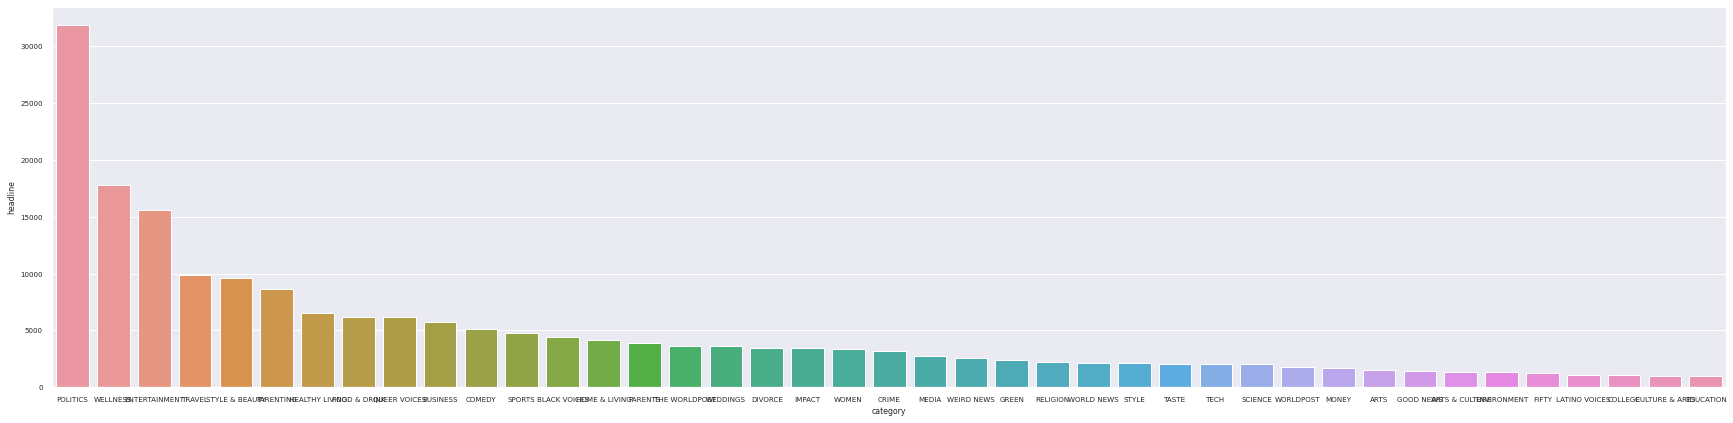

In [13]:
plt.figure(figsize=(30,7))
sns.set(font_scale=0.65)
sns.barplot(top_df['category'],top_df['headline'])

#### The dataset is also skewed. We ll have to find prominent features to avoid under fitting if required

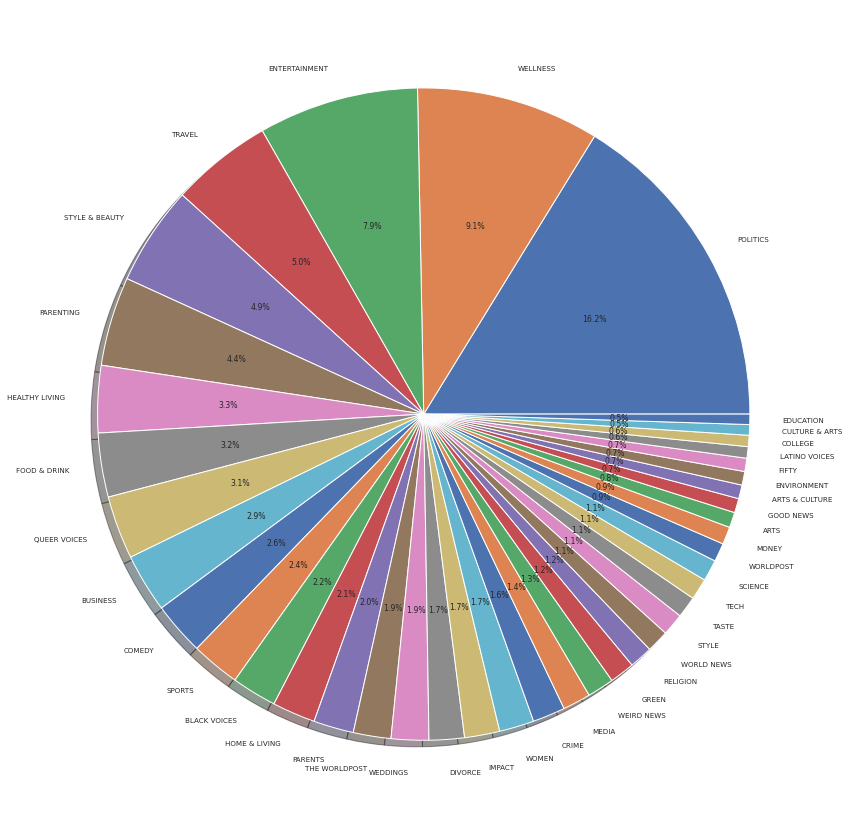

In [14]:
plt.figure(figsize=(15,15))
source_pie = plt.pie(top_df['headline'], labels=top_df['category'], autopct='%1.1f%%', shadow=True)

#### Conclusion: Polictics , Welness and Entertainment sector contribute majority of 33%. They should be focused more.

# Section 2 : headline , short_description (length)

In [15]:
df.head(2)

,category,headline,authors,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.


In [0]:
def sentence_len(text):
  return len(text.split())

In [0]:
df['headline_length'] = data.headline.apply(sentence_len)

In [0]:
df['short_description_length'] = data.short_description.apply(sentence_len)

In [19]:
df.head()

,category,headline,authors,short_description,headline_length,short_description_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,14,13
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,14,6
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...,10,15
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...,11,14
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ...",13,13


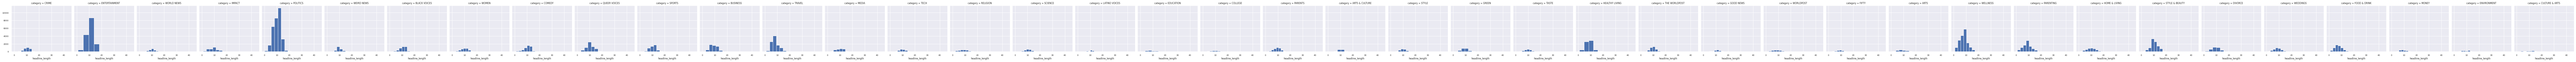

In [20]:
g = sns.FacetGrid(df,col='category')
g.map(plt.hist,'headline_length')

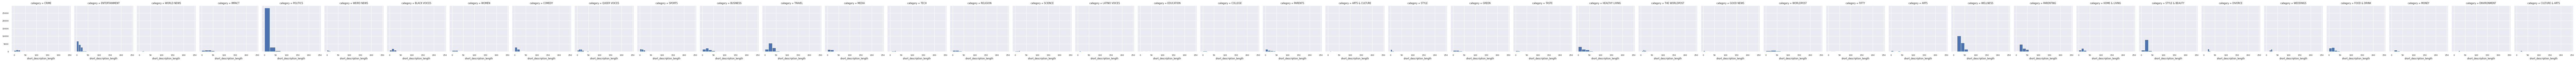

In [21]:
g = sns.FacetGrid(df,col='category')
g.map(plt.hist,'short_description_length')

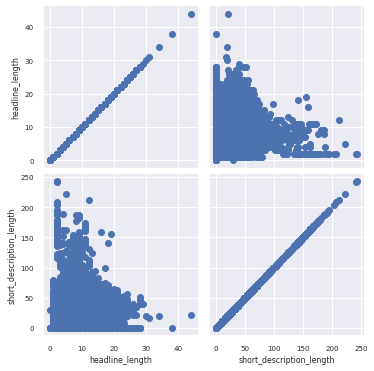

In [22]:
g = sns.PairGrid(df)
g = g.map(plt.scatter)

In [23]:
df.corrwith(df.short_description_length)

headline_length            -0.238561
short_description_length    1.000000
dtype: float64

### No relationship between length of headline and description. (No causalty)
#### Now, we can combine the information

In [24]:
df['information'] = df['headline']+'. '+df['short_description']
df.head(1)

,category,headline,authors,short_description,headline_length,short_description_length,information
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,14,13,There Were 2 Mass Shootings In Texas Last Week...


In [25]:
df.loc[0].information

'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV. She left her husband. He killed their children. Just another day in America.'

In [26]:
df['info_length'] = df.information.apply(sentence_len)
df.head(2)

,category,headline,authors,short_description,headline_length,short_description_length,information,info_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,14,13,There Were 2 Mass Shootings In Texas Last Week...,27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,14,6,Will Smith Joins Diplo And Nicky Jam For The 2...,20


In [27]:
bycategory = df.groupby('category')
bycategory['info_length'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
ARTS,1490.0,30.595302,19.505763,2.0,11.0,34.0,47.00,109.0
ARTS & CULTURE,1339.0,23.277819,6.105736,8.0,19.0,23.0,27.00,52.0
BLACK VOICES,4384.0,28.049042,11.103997,2.0,21.0,27.0,33.00,110.0
BUSINESS,5705.0,32.238212,14.953828,1.0,23.0,31.0,42.00,153.0
COLLEGE,1094.0,32.497258,17.335068,1.0,21.0,30.0,45.00,191.0
COMEDY,5154.0,22.523671,11.490068,1.0,15.0,21.0,29.00,128.0
CRIME,3167.0,24.741080,10.649022,2.0,18.0,25.0,31.00,98.0
CULTURE & ARTS,1030.0,34.902913,10.264826,4.0,29.0,33.0,39.00,87.0
DIVORCE,3426.0,34.759194,9.116158,10.0,29.0,33.0,38.00,76.0


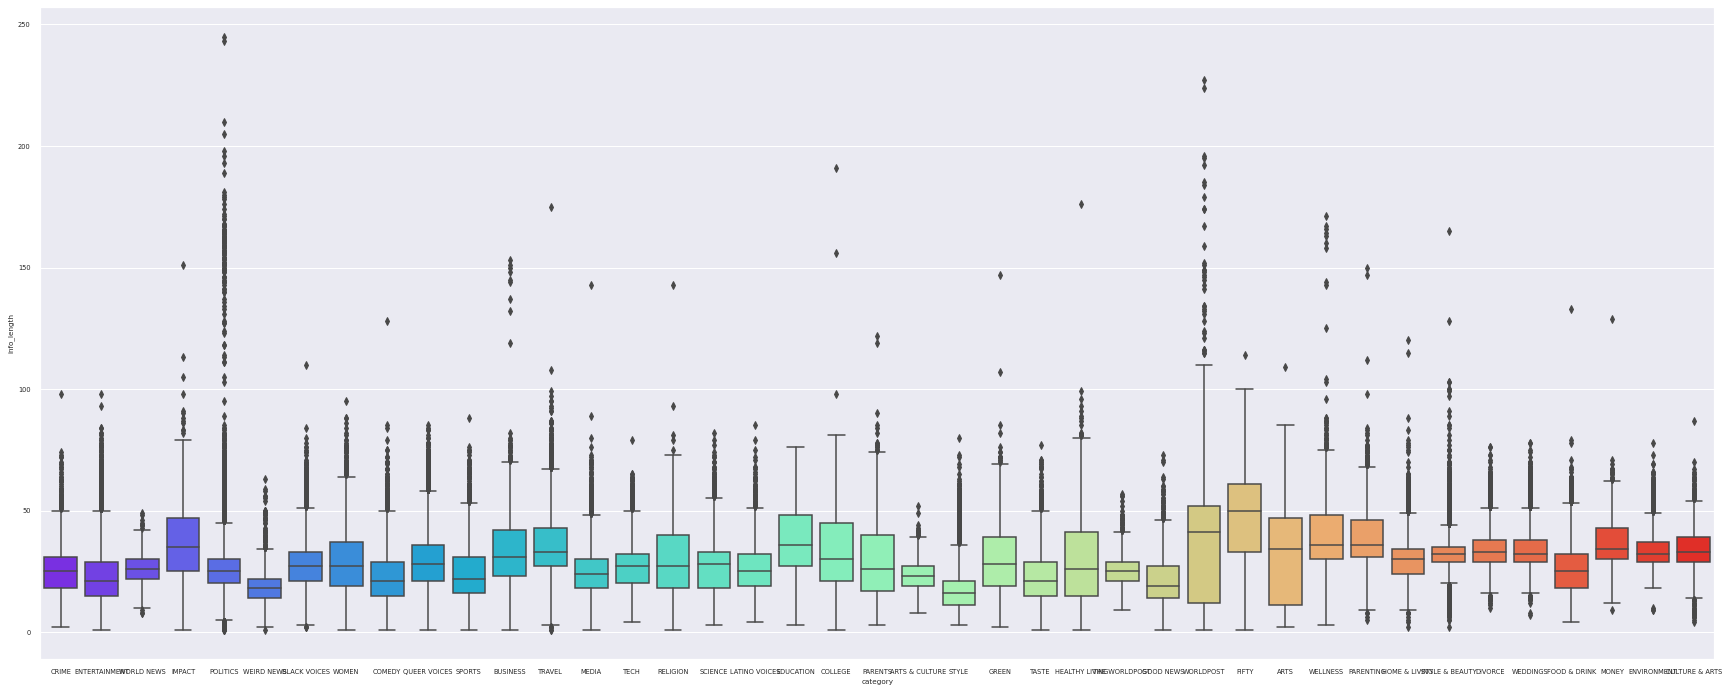

In [28]:
plt.figure(figsize=(30,12))
sns.set(font_scale=0.6)
sns.boxplot(x='category',y='info_length',data=df,palette='rainbow')

In [0]:
mean_headline_length = bycategory['info_length'].describe()['mean']

In [30]:
mean_df = pd.DataFrame(mean_headline_length)
mean_df=mean_df.reset_index()
mean_df.head(2)

,category,mean
0,ARTS,30.595302
1,ARTS & CULTURE,23.277819


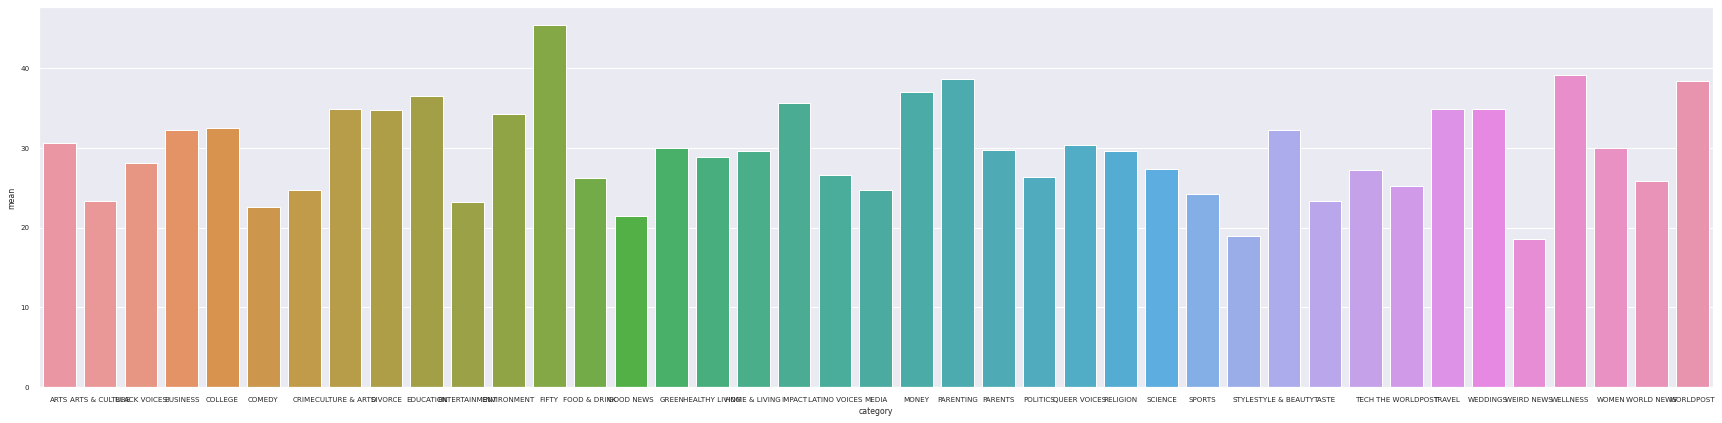

In [31]:
plt.figure(figsize=(30,7))
sns.set(font_scale=0.65)
sns.barplot(mean_df['category'],mean_df['mean'])

### Length of information doesn't seem to be a distinguishing feature for categories

## SECTION 3 : Authors

In [32]:
nb_authors =df.authors.nunique()
nb_authors

27993

In [33]:
authors = pd.DataFrame(df.authors.value_counts()).reset_index()[1:]
authors.columns = ['author','contributions']
authors

,author,contributions
1,Lee Moran,2423
2,Ron Dicker,1913
3,"Reuters, Reuters",1562
4,Ed Mazza,1322
5,Cole Delbyck,1140
...,...,...
27988,"Grace Nasri, Contributor\nCommunications profe...",1
27989,"Anna Sterling, HuffPost",1
27990,"John Taylor, Contributor\nPresident and CEO of...",1
27991,"Caterina Sullivan, ContributorCEO, Global Goal...",1


In [34]:
total_contributions =authors.contributions.sum()
total_contributions

164233

In [0]:
frequent_author = []
author_count = 0
sum_contribution= 0
for author,contribution in authors.values:
  author_count += 1
  if contribution < 70:
    break;
  #print(author,contribution)
  sum_contribution += contribution


In [36]:
print(author_count)
print(sum_contribution)

289
82271


In [37]:
print(" {frequent_author_percentage}% of the authors have contributed {frequent_author_contributions}% of conrtibutions".format(
    frequent_author_percentage=(author_count/nb_authors)*100,frequent_author_contributions=(sum_contribution/total_contributions)*100))

 1.0324009573822026% of the authors have contributed 50.094073663636415% of conrtibutions


### Nearly 1% of authors contribute for about 50% of total contributions.

In [38]:
df.authors.value_counts()

                                                                                                      32157
Lee Moran                                                                                              2423
Ron Dicker                                                                                             1913
Reuters, Reuters                                                                                       1562
Ed Mazza                                                                                               1322
                                                                                                      ...  
Grace Nasri, Contributor\nCommunications professional                                                     1
Anna Sterling, HuffPost                                                                                   1
John Taylor, Contributor\nPresident and CEO of the National Community Reinvestment Coali...               1
Caterina Sullivan, Contribut

In [39]:
df.authors.value_counts().mean()

7.015682492051584

In [0]:
author_name = 'Lee Moran'
byauthor = df[df.authors == author_name].groupby('category')
author_contrib =byauthor.describe()['info_length']['count']

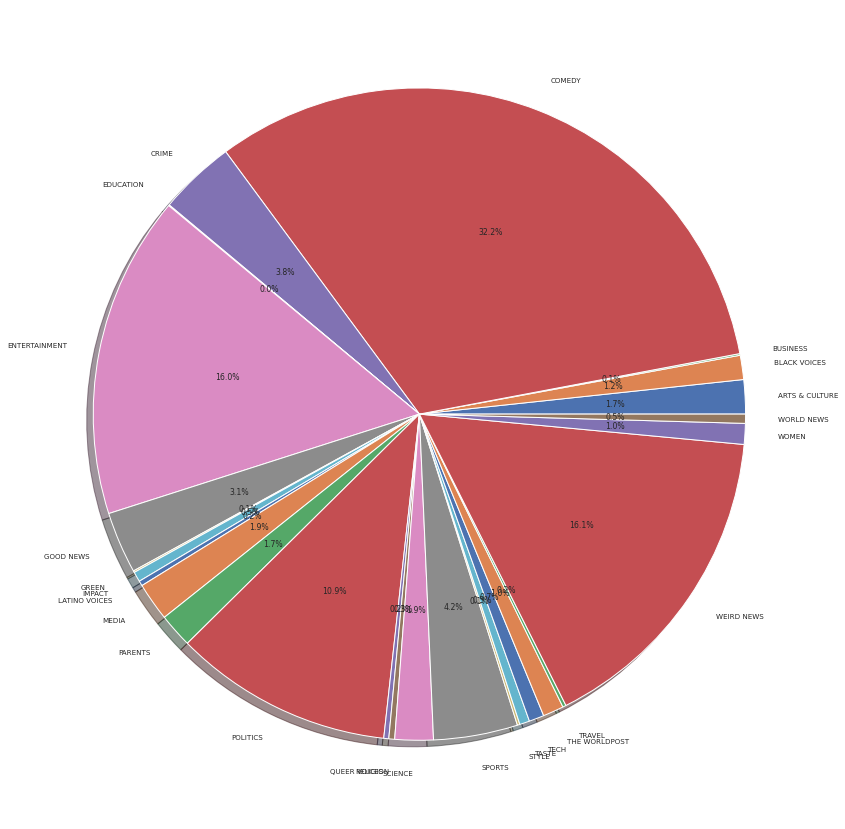

In [41]:
plt.figure(figsize=(15,15))
source_pie = plt.pie(author_contrib.values, labels=author_contrib.index, autopct='%1.1f%%', shadow=True)

##### Among the frequent authors , even though every author has contributions in almost all the areas. There are still majority contribution categories for each one of the author. Hence every author can be mapped to a category

Conclusion: Authors can be used as a distingusing feature for categories

## TRAINING (Without much pre processing)

In [0]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [94]:
nb.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# RESULTS

### Naive Bayes: 59%

In [95]:
predictions = nb.predict(X_test)

from sklearn.metrics import confusion_matrix,classification_report

print(confusion_matrix(Y_test,predictions))
print('\n')
print(classification_report(Y_test,predictions))

[[ 50  16   0 ...   2   0   2]
 [  9  35   5 ...   3   1   0]
 [  1   0 336 ...   2   0   0]
 ...
 [  0   0   8 ... 173   0   0]
 [  0   0   0 ...   2  55   4]
 [  0   0   1 ...   3   4  36]]


                precision    recall  f1-score   support

          ARTS       0.59      0.11      0.19       451
ARTS & CULTURE       0.65      0.09      0.16       394
  BLACK VOICES       0.74      0.26      0.39      1283
      BUSINESS       0.53      0.37      0.44      1718
       COLLEGE       0.83      0.05      0.10       349
        COMEDY       0.72      0.44      0.54      1454
         CRIME       0.58      0.56      0.57       958
CULTURE & ARTS       0.60      0.04      0.07       313
       DIVORCE       0.84      0.54      0.66      1002
     EDUCATION       0.80      0.04      0.07       319
 ENTERTAINMENT       0.55      0.84      0.67      4717
   ENVIRONMENT       0.93      0.06      0.12       401
         FIFTY       0.50      0.00      0.01       401
  FOOD & DRINK       

### SVM : 68%

In [96]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train,Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [97]:
predictions = model.predict(X_test)

from sklearn.metrics import confusion_matrix,classification_report

print(confusion_matrix(Y_test,predictions))
print('\n')
print(classification_report(Y_test,predictions))

[[143  43  10 ...   6   1   5]
 [ 55 170   4 ...   5   0   1]
 [  6   3 616 ...  15   3   3]
 ...
 [  3   1  16 ... 388   4   6]
 [  3   1   2 ...   2 160  23]
 [  3   1   3 ...   8  15 206]]


                precision    recall  f1-score   support

          ARTS       0.41      0.32      0.36       451
ARTS & CULTURE       0.61      0.43      0.51       394
  BLACK VOICES       0.63      0.48      0.54      1283
      BUSINESS       0.51      0.49      0.50      1718
       COLLEGE       0.53      0.46      0.49       349
        COMEDY       0.65      0.62      0.63      1454
         CRIME       0.58      0.61      0.59       958
CULTURE & ARTS       0.51      0.38      0.44       313
       DIVORCE       0.78      0.74      0.76      1002
     EDUCATION       0.50      0.40      0.44       319
 ENTERTAINMENT       0.75      0.79      0.77      4717
   ENVIRONMENT       0.51      0.31      0.39       401
         FIFTY       0.46      0.30      0.37       401
  FOOD & DRINK       